# Cell type differences in PBMCs

### Load the data

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
data_path = '/data_volume/memento/demux/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read the data

In [6]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells', 'Dendritic cells', 'Megakaryocytes']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B', 'DC', 'Mega']))

In [7]:
def simplify_name(name):
    return name.split('.')[0]

In [8]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()
adata.X = adata.X.astype(np.int64)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
# temp_adata = adata.copy()
# temp_adata = temp_adata[temp_adata.obs.cell == ct].copy()
norm_adata = adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
# sc.pp.log1p(norm_adata)

In [10]:
adata.obs['ct'] = adata.obs['cell'].apply(lambda x: label_converter[x])

In [11]:
adata.shape

(24495, 35635)

In [12]:
adata.obs.cell.value_counts()

CD4 T cells          10342
CD14+ Monocytes       5341
B cells               2564
CD8 T cells           2035
NK cells              1988
FCGR3A+ Monocytes     1586
Dendritic cells        432
Megakaryocytes         207
Name: cell, dtype: int64

In [13]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

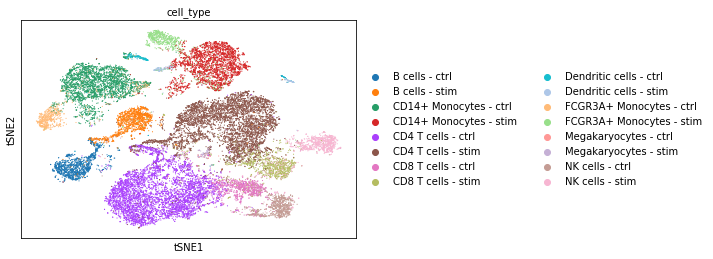

In [14]:
sc.pl.tsne(adata, color='cell_type')

In [15]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [16]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [17]:
with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
	tfs = pkl.load(f)

### Read TFs

In [18]:
tf_df = pd.read_csv('../ifn_hbec/version3/baseline/human_tf.txt', sep='\t')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA', 'NLRC5']

### Select control cells

In [25]:
cts = ['Th', 'cM']

In [26]:
ctrl_adata = adata[
    adata.obs['ct'].isin(cts) & \
    adata.obs['stim'].isin(['ctrl'])].copy().copy()

### Setup memento

In [27]:
ctrl_adata.obs['q'] = 0.07

In [28]:
ctrl_adata.X = ctrl_adata.X.astype(float)

In [29]:
memento.setup_memento(ctrl_adata, q_column='q', trim_percent=0.1, filter_mean_thresh=0.07)

Version 0.0.6


### Get highly expressed TFs

### Test pairs of these highly expressed genes

In [50]:
simplified_cts = ['T', 'B', 'M']
for ct in ['Th']:
    print(ct)
    
    labeled_ctrl_adata = ctrl_adata.copy().copy()
    labeled_ctrl_adata.obs['is_ct'] = labeled_ctrl_adata.obs['ct'].str.contains(ct).astype(int)
    
    memento.create_groups(labeled_ctrl_adata, label_columns=['is_ct', 'ind', 'ct'])
    
    memento.compute_1d_moments(labeled_ctrl_adata, min_perc_group=.7)
    
    available_tfs = set(tf_list) & set(labeled_ctrl_adata.var.index)
    available_genes = set(labeled_ctrl_adata.var.index)
    print(len(available_tfs),labeled_ctrl_adata.shape)
    memento.compute_2d_moments(labeled_ctrl_adata, list(itertools.product(available_tfs, available_genes)))
    
#     memento.compute_2d_moments(labeled_ctrl_adata, list(itertools.combinations(available_genes, 2)))
    
    
    candidates = memento.get_2d_moments(labeled_ctrl_adata, groupby='is_ct').query('is_ct_1 > 0.15 | is_ct_0 > 0.15')
    print(candidates.shape)
    memento.compute_2d_moments(labeled_ctrl_adata, list(zip(candidates['gene_1'], candidates['gene_2'])))
    
    memento.ht_2d_moments( 
        labeled_ctrl_adata, 
        formula_like='1 + is_ct + ind',
        treatment_col='is_ct', 
        num_boot=10000, 
        verbose=1,
        num_cpus=94,
        resampling='permutation',
        approx=False)
    labeled_ctrl_adata.write(data_path + 'coex_markers/Th_vs_cM.h5ad'.format(ct))

Th
55 (7905, 1298)
(15336, 4)


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    1.8s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:    9.3s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   22.8s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   39.6s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:   55.9s
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:  1.4min
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:  1.8min
[Parallel(n_jobs=94)]: Done 3862 tasks      | elapsed:  2.3min
[Parallel(n_jobs=94)]: Done 4812 tasks      | elapsed:  2.9min
[Parallel(n_jobs=94)]: Done 5862 tasks      | elapsed:  3.5min
[Parallel(n_jobs=94)]: Done 7012 tasks      | elapsed:  4.1min
[Parallel(n_jobs=94)]: Done 8262 tasks      | elapsed:  5.1min
[Parallel(n_jobs=94)]: Done 9612 tasks      | elapsed:  5.9min
[Parallel(n_jobs=94)]: Done 11062 tasks      | elapsed:  6.8min
[Parallel(n_jobs=94)]: Done 12612 tasks    

### Make a heatmap

In [51]:
ht_result_all = []
for ct in ['Th_vs_cM']:
    result = sc.read(data_path + 'coex_markers/{}.h5ad'.format(ct))
    ht_result = memento.get_2d_ht_result(result)
    ht_result['corr_fdr'] = memento.util._fdrcorrect(ht_result['corr_pval'])
    ht_result['ct'] = ct
    ht_result_all.append(ht_result)
ht_result_all = pd.concat(ht_result_all)
ht_result_all['sign'] = ht_result_all['corr_coef'] > 0
sig_df = ht_result_all.query('corr_fdr < 0.1')
pairs = sig_df[['gene_1', 'gene_2']].drop_duplicates()

In [64]:
labeled_ctrl_adata = ctrl_adata.copy().copy()
memento.create_groups(labeled_ctrl_adata, label_columns=['ct', 'ind'])
memento.compute_1d_moments(labeled_ctrl_adata, min_perc_group=.7)
memento.compute_2d_moments(labeled_ctrl_adata, list(zip(ht_result_all['gene_1'], ht_result_all['gene_2'])))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [65]:
corr_df = memento.get_2d_moments(labeled_ctrl_adata, groupby='ct')

In [58]:
heatmap = corr_df.query('gene_1 == "TCF25"')#[['ct_cM', 'ct_Th']]
heatmap.index = heatmap['gene_2']
heatmap = heatmap[['ct_cM', 'ct_Th']]

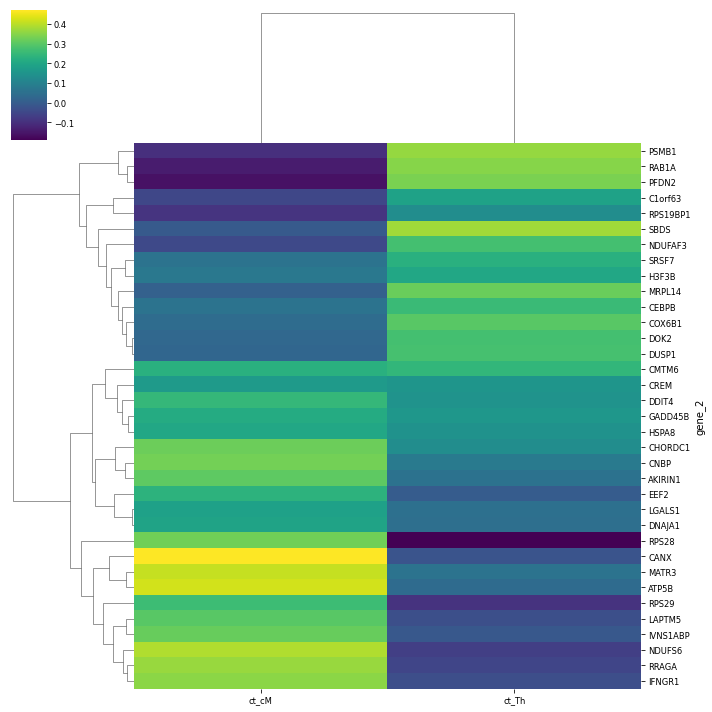

In [59]:
sns.clustermap(heatmap, cmap='viridis')

In [98]:
subsets = {}
for tf in ht_result_all.gene_1.drop_duplicates():
    
    subset = ht_result_all.query('gene_1 == "{}"'.format(tf)).copy()
    subset['corr_fdr'] = memento.util._fdrcorrect(subset['corr_pval'])
    
    # Pick some highly correlated genes that don't change
    subset_1 = subset.query('corr_pval > 0.9').head(25)
    subset_1['type'] = 'both'
    subset_2 = subset.query('corr_fdr < 0.1 & corr_coef > 0').sort_values('corr_pval').head(25)
    subset_2['type'] = 'T'
    subset_3 = subset.query('corr_fdr < 0.1 & corr_coef < 0').sort_values('corr_pval').head(25)
    subset_3['type'] = 'M'
    
    subsets[tf] = pd.concat([subset_2, subset_1, subset_3])

In [80]:
heatmap = subsets['SUB1'].merge(corr_df)
heatmap.index = heatmap['gene_2']
heatmap = heatmap[['ct_cM', 'ct_Th']]

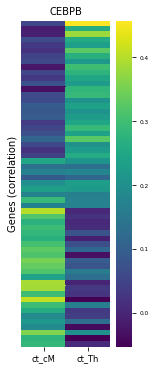

In [100]:
tf = 'CEBPB'
heatmap = subsets[tf].merge(corr_df)
heatmap.index = heatmap['gene_2']
heatmap = heatmap[['ct_cM', 'ct_Th']]

plt.figure(figsize=(2,6))
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)
sns.heatmap(heatmap, cmap='viridis', yticklabels=False)
plt.ylabel('Genes (correlation)'); plt.title(tf)
plt.savefig('{}_heatmap.png'.format(tf), dpi=800, bbox_inches='tight')

In [30]:
ct = 'Th_tf'
result = sc.read(data_path + 'coex_markers/{}.h5ad'.format(ct))
ht_result = memento.get_2d_ht_result(result)
ht_result['corr_fdr'] = memento.util._fdrcorrect(ht_result['corr_pval'])

moments = memento.get_2d_moments(result, groupby='is_ct')
moments_1d = memento.get_1d_moments(result, groupby='ct')
merged = moments.merge(ht_result, on=['gene_1', 'gene_2'])

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log


In [31]:
merged.query('corr_fdr < 0.1 & is_ct_0 < 0.2').sort_values('is_ct_1')

gene_1    gene_2   is_ct_0   is_ct_1  corr_coef   corr_se  corr_pval  \
543    IRF1    CACYBP  0.168879  0.250512   0.524179  0.095558   0.000091   
644     SON      EIF1  0.185241  0.250724   0.395833  0.097786   0.000442   
96     SUB1    CACYBP  0.145872  0.251458   0.442402  0.065677   0.000028   
58     JUNB      OAZ1  0.192999  0.251568   0.202168  0.029864   0.000350   
298    ATF4      PIM3  0.187114  0.252371   0.378492  0.118111   0.001500   
565   CEBPB     FKBP2  0.169543  0.252413   0.243494  0.083617   0.004100   
180     JUN     HSPA8  0.141976  0.252914   0.430849  0.043990   0.000032   
184     JUN      OAZ1  0.178517  0.252951   0.406973  0.026159   0.000018   
561    IRF1      ARF4  0.117926  0.253062   0.417843  0.105351   0.000349   
641     SON    CACYBP  0.175421  0.253202   0.395976  0.107805   0.000922   
321  ZNF207     SRSF2  0.194819  0.254866   0.250254  0.101904   0.014799   
120    SUB1     PHF5A  0.120472  0.256299   0.341642  0.116794   0.003700   
548    IRF1    DNAJA1  0.180431  0.256375   0.338272  0.080706   0.000545   
350    ELF1     TXNIP  0.188966  0.256502   0.309536  0.139357   0.027397   
237    CREM    NFE2L2  0.192606  0.256805   0.351767  0.094010   0.000666   
23   NFE2L2      CREM  0.192606  0.256805   0.351767  0.094010   0.000666   
109    SUB1     PSMB1  0.197619  0.257468   0.353024  0.076453   0.000214   
55     JUNB     CALM2  0.189912  0.258441   0.273003  0.066838   0.000460   
178     JUN      SDF2  0.115276  0.259203   0.416796  0.100518   0.000373   
655     SON     SUMO1  0.192190  0.259230   0.401862  0.152182   0.008999   
657     SON     OSER1  0.186416  0.259604   0.560288  0.176908   0.001600   
51     JUNB     HSPA8  0.193731  0.259803   0.322992  0.034874   0.000071   
264    ATF4      TCP1  0.161329  0.260804   0.420971  0.111385   0.000706   
544    IRF1      VAPA  0.168636  0.262322   0.356135  0.092955   0.000844   
110    SUB1      TAP1  0.150660  0.262481   0.386975  0.106596   0.000987   
613   GPBP1   C1orf63  0.199212  0.262596   0.306384  0.105841   0.004400   
102    SUB1     SRSF7  0.174493  0.262802   0.197839  0.041422   0.000275   
198     JUN   GADD45B  0.197400  0.263301   0.407317  0.088793   0.000398   
546    IRF1      ATF4  0.168550  0.263973   0.262516  0.102170   0.009399   
304    ATF4      IRF1  0.168550  0.263973   0.262516  0.102170   0.009399   
614   GPBP1     TXNIP  0.145893  0.266675   0.286706  0.074380   0.000938   
179     JUN    CACYBP  0.180282  0.267051   0.444963  0.067868   0.000129   
53     JUNB      EIF1  0.199330  0.267425   0.297155  0.030080   0.000110   
418    CNBP    COX7A2  0.144847  0.268943   0.506317  0.108633   0.000371   
263    ATF4     HSPA8  0.188215  0.269672   0.506014  0.081471   0.000162   
185     JUN     HSPB1  0.199800  0.269801   0.326822  0.071940   0.001024   
138    SUB1    NHP2L1  0.183403  0.271351   0.301742  0.060775   0.000673   
201     JUN      ARF4  0.180283  0.272531   0.280267  0.098743   0.004800   
446    CNBP      SUB1  0.171820  0.272935   0.320522  0.091567   0.001054   
114    SUB1      CNBP  0.171820  0.272935   0.320522  0.091567   0.001054   
571   NR3C1      SRGN  0.198929  0.273169   0.371692  0.027176   0.000003   
553    IRF1   C1orf63  0.183059  0.273286   0.318032  0.063332   0.000129   
602   GPBP1    PPP1R2  0.196837  0.273349   0.274288  0.113304   0.016098   
71     JUNB    PPP1R2  0.177924  0.278511   0.426253  0.057931   0.000113   
274    ATF4     RAB1A  0.138968  0.278802   0.504263  0.123697   0.000637   
126    SUB1  MAP1LC3B  0.194926  0.280653   0.151818  0.080144   0.059794   
244    CREM      SUB1  0.191809  0.281320   0.301560  0.048446   0.000058   
129    SUB1      CREM  0.191809  0.281320   0.301560  0.048446   0.000058   
322  ZNF207      OAZ1  0.165390  0.281767   0.366194  0.086716   0.000539   
305    ATF4      ARF4  0.112837  0.282084   0.523712  0.088826   0.000066   
98     SUB1     CD164  0.153981  0.282275   0.322924  0.088765   0.001060   
1

In [22]:
merged['sign'] = merged['corr_coef']>0

In [23]:
merged.query('corr_fdr < 0.1').groupby('gene_1').agg({'sign':['count', 'mean']})

sign          
        count      mean
gene_1                 
ARID4B      1  1.000000
ARID5A      1  1.000000
ATF4       33  1.000000
CEBPB       1  1.000000
CNBP       37  1.000000
CREM       53  1.000000
ELF1        6  1.000000
GPBP1      38  1.000000
GTF3A       1  0.000000
HMGA1       1  0.000000
HMGB1       1  0.000000
ID2         1  1.000000
IRF1       18  1.000000
IRF7        3  0.000000
JUN        23  1.000000
JUNB       28  0.964286
KLF6        4  1.000000
LRRFIP1     6  1.000000
MAX         1  1.000000
NFE2L2     12  1.000000
NR3C1       1  1.000000
SFPQ        6  1.000000
SON         9  1.000000
SUB1       25  1.000000
XBP1        3  0.000000
YBX1       57  0.000000
ZNF207     12  1.000000
ZNF706      2  0.500000

In [71]:
moments_1d[0].query('gene == "IRF1"')

gene   is_ct_0   is_ct_1
412  IRF1 -1.365336 -1.961901

In [ ]:
moments.query('gene_2 == "ATF4"')

In [88]:
merged['sign'] = merged['corr_coef'] > 0
hit_tfs = merged.query('corr_fdr < 0.1').gene_1.value_counts()
hit_tfs = hit_tfs[hit_tfs > 25].index.tolist()

In [89]:
print(merged.query('corr_fdr < 0.1 & gene_1 in @hit_tfs').groupby('gene_1').sign.mean().sort_values())

gene_1
YBX1       0.000000
HMGB1      0.009174
ZFP36L2    0.027027
LYAR       0.040000
BCLAF1     0.507463
SUB1       0.520833
ZNF24      0.590909
CNBP       0.634921
LRRFIP1    0.666667
GPBP1      0.682927
ELF1       0.758621
ZNF394     0.769231
SFPQ       0.894737
NFE2L2     0.909091
CREM       0.938776
HBP1       0.950820
DNAJC2     0.966292
KLF6       0.973684
ATF4       0.975155
JUNB       0.987013
SON        0.991071
JUN        1.000000
IRF1       1.000000
Name: sign, dtype: float64


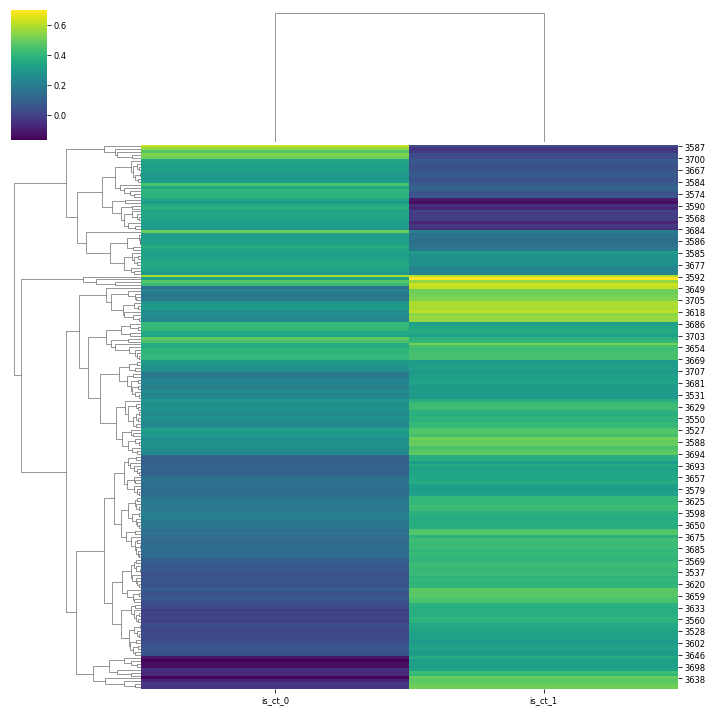

In [95]:
tf = 'GPBP1'
heatmap = merged.query('gene_1 == "{}"'.format(tf))
sns.clustermap(heatmap[['is_ct_0', 'is_ct_1']], cmap='viridis')

In [ ]:
merged

In [ ]:
heatmap = pd.DataFrame()

In [71]:
ct = 'Th'
result = sc.read(data_path + 'coex_markers/{}.h5ad'.format(ct))
ht_result = memento.get_2d_ht_result(result)
ht_result['corr_fdr'] = memento.util._fdrcorrect(ht_result['corr_pval'])

moments = memento.get_2d_moments(result, groupby='is_ct')
merged = moments.merge(ht_result, on=['gene_1', 'gene_2'])

In [82]:
merged.query('corr_fdr < 0.1 & (is_ct_0 < 0.1 | is_ct_1 < 0.1)')

gene_1 gene_2   is_ct_0   is_ct_1  corr_coef   corr_se  corr_pval  \
340     ATF4  EIF4H  0.058752  0.301934   0.610993  0.181254   0.000991   
345     ATF4   ARF4  0.081530  0.344388   0.740580  0.127819   0.000162   
392  ZFP36L1  RAB1A  0.053805  0.300376   0.300522  0.090425   0.002100   
397     SUB1  YPEL5  0.093573  0.318884   0.566976  0.045304   0.000133   
465     IRF1  EIF4H  0.095610  0.316678   0.378998  0.105649   0.001561   
566     YBX1  G3BP1  0.394136  0.061501  -0.411547  0.090068   0.000592   
835     SFPQ   SRP9  0.303251  0.094762  -0.303623  0.144495   0.035396   

     corr_fdr  
340  0.007060  
345  0.002961  
392  0.010034  
397  0.002606  
465  0.008584  
566  0.005131  
835  0.090737

In [70]:
ht_result.query('corr_fdr < 0.1').head()

gene_1    gene_2  corr_coef   corr_se  corr_pval  corr_fdr
0      JUN    DNAJA1   0.471603  0.084050   0.000102  0.002435
2      JUN     SRSF2   0.270539  0.071986   0.001842  0.009278
3      JUN  HSP90AB1   0.489864  0.076586   0.000019  0.001592
4      JUN    CACYBP   0.439569  0.078399   0.000171  0.002994
6      JUN      EIF5   0.298735  0.077984   0.002026  0.009849
..     ...       ...        ...       ...        ...       ...
816   SFPQ      EIF1   0.221347  0.100727   0.025197  0.069755
822   SFPQ     OSER1   0.263952  0.116262   0.022698  0.064056
823   SFPQ     SNRPG   0.550459  0.175456   0.001400  0.008119
835   SFPQ      SRP9  -0.303623  0.144495   0.035396  0.090737
837   SFPQ      MTDH  -0.344766  0.144061   0.017898  0.054341

[331 rows x 6 columns]

In [66]:
candidates.shape

(828, 4)

In [54]:
labeled_ctrl_adata.var

gene_ids     mt     hb  n_cells_by_counts  mean_counts  \
index                                                                     
ISG15     ENSG00000187608  False  False              14816    19.357071   
AURKAIP1  ENSG00000175756  False  False               5348     0.257083   
MRPL20    ENSG00000242485  False  False               3650     0.170389   
SSU72     ENSG00000160075  False  False               4414     0.212945   
RER1      ENSG00000157916  False  False               5263     0.264297   
...                   ...    ...    ...                ...          ...   
MRPS6     ENSG00000243927  False  False               3053     0.145260   
HMGN1     ENSG00000205581  False  False               8509     0.480971   
U2AF1     ENSG00000160201  False  False               8353     0.471284   
CSTB      ENSG00000160213  False  False               8738     1.165079   
PRMT2     ENSG00000160310  False  False               4449     0.220079   

          log1p_mean_counts  pct_dropout_by_counts  total_counts  \
index                                                              
ISG15              3.013428              39.950553      477597.0   
AURKAIP1           0.228794              78.324484        6343.0   
MRPL20             0.157336              85.206501        4204.0   
SSU72              0.193052              82.109999        5254.0   
RER1               0.234516              78.668990        6521.0   
...                     ...                    ...           ...   
MRPS6              0.135632              87.626150        3584.0   
HMGN1              0.392698              65.512909       11867.0   
U2AF1              0.386136              66.145179       11628.0   
CSTB               0.772457              64.584769       28746.0   
PRMT2              0.198915              81.968143        5430.0   

          log1p_total_counts  
index                         
ISG15              13.076525  
AURKAIP1            8.755264  
MRPL20              8.344029  
SSU72               8.566936  
RER1                8.782936  
...                      ...  
MRPS6               8.184514  
HMGN1               9.381601  
U2AF1               9.361258  
CSTB               10.266289  
PRMT2               8.599878  

[879 rows x 9 columns]

In [21]:
def plot_microscopy(X, c1, c2, s=5, q_up=.95, q_doawn=0.1, min_val=0.1, alpha=0.1, xlim=None, ylim=None, remove_axis=True):
    
    N = X.shape[0]
    
    c1 = np.clip(c1, a_min=np.quantile(c1, q_down), a_max=np.quantile(c1, q_up))
    c2 = np.clip(c2, a_min=np.quantile(c2, q_down), a_max=np.quantile(c2, q_up))

    c1 = (c1 - c1.min())/(c1.max()-c1.min())
    c2 = (c2 - c2.min())/(c2.max()-c2.min())
    
    c1 = np.clip(c1, a_min=min_val, a_max=1)
    c2 = np.clip(c2, a_min=min_val, a_max=1)
    
    plt.subplot(1, 3, 1); plt.scatter(X[:, 0], X[:, 1], c=np.vstack([c1, np.zeros(N), np.zeros(N)]).T, s=s, alpha=alpha)
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
        
    plt.subplot(1, 3, 2); plt.scatter(X[:, 0], X[:, 1], c=np.vstack([np.zeros(N), c2, np.zeros(N)]).T, s=s, alpha=alpha)
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
        
    plt.subplot(1, 3, 3); plt.scatter(X[:, 0], X[:, 1], c=np.vstack([c1, c2, np.zeros(N)]).T, s=s, alpha=alpha)
    plt.gca().set_facecolor((0, 0, 0))
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    
def get_ct_ind_corr(adata, gene_1, gene_2):
    
    adata_temp = adata.copy()
    scmemo.create_groups(adata_temp, label_columns=['cell', 'stim','ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_temp, inplace=True, filter_genes=False, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.125, 
        min_perc_group=0.99)
    scmemo.compute_2d_moments(adata_temp, [gene_1], [gene_2])
    df_list = []
    for group in adata_temp.uns['scmemo']['groups']:
        _, ct, stim, ind = group.split('^')
        if ct not in cts:
            continue
        df_list.append((label_converter[ct], stim,ind,adata_temp.uns['scmemo']['2d_moments'][group]['corr'][0][0]))
    df = pd.DataFrame(df_list, columns=['ct', 'stim','ind', 'corr']).sort_values('ct')
    df['corr'] = df['corr'].apply(lambda x: np.nan if abs(x) > 1 else x)
    
    return df
    

In [22]:
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(estimator)

adata_dict = {}
for ct in cts:
    print('Processing', ct)
    adata_ct =  adata[adata.obs.stim == 'ctrl'].copy()
#     adata_ct.obs['cell'] = np.random.choice(adata_ct.obs['cell'], adata_ct.shape[0], replace=False)
    adata_ct.obs['ct'] = adata_ct.obs['cell'].apply( lambda x: int(x == ct))# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
    scmemo.create_groups(adata_ct, label_columns=['ct', 'cell' ,'ind'], inplace=True)

    scmemo.compute_1d_moments(
        adata_ct, inplace=True, filter_genes=True, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.25, 
        min_perc_group=0.99)
    print('Size of data', adata_ct.shape)

    available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
    target_genes = adata_ct.var.index.tolist()
    target_genes = [gene for gene in target_genes if gene[:2] != 'RP' and gene[:3] != 'HLA']
    # target_genes = np.random.choice(target_genes, 50)
    print('TF list length', len(available_tfs))
    print('target gene length', len(target_genes))
    scmemo.compute_2d_moments(adata_ct, target_genes, target_genes)
    
    scmemo.ht_2d_moments(adata_ct, formula_like='1 + ct', cov_column='ct', num_boot=5000, num_cpus=6)
    adata_ct.write(data_path + 'result_2d/ct_specific_{}_05292020.h5ad'.format(label_converter[ct]))
    
    adata_dict[ct] = adata_ct.copy()

Processing CD4 T cells
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   10.5s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing CD14+ Monocytes
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    9.9s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing FCGR3A+ Monocytes
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    9.5s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing NK cells
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   10.3s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing CD8 T cells
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing B cells
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    9.4s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


In [13]:
adata_dict = {}
for ct in cts:
    adata_dict[ct] = sc.read(data_path + 'result_2d/ct_specific_{}_05292020.h5ad'.format(label_converter[ct]))

In [15]:
def get_2d_ht_result(adata):
	
	result_df = pd.DataFrame(
		itertools.product(
			adata.uns['scmemo']['2d_moments']['gene_1'],
			adata.uns['scmemo']['2d_moments']['gene_2']),
		columns=['gene_1', 'gene_2'])
	result_df['corr_coef'] = adata.uns['scmemo']['2d_ht']['corr_coef'].ravel()
	result_df['corr_pval'] = adata.uns['scmemo']['2d_ht']['corr_asl'].ravel()
	result_df['corr_fdr'] = util._fdrcorrect(result_df['corr_pval'].values)
	
	return result_df

In [18]:
for ct in cts:
    print(ct)
    print(get_2d_ht_result(adata_dict[ct]).query('corr_fdr < 0.15').shape)

CD4 T cells
(26, 5)
CD14+ Monocytes
(0, 5)
FCGR3A+ Monocytes
(2, 5)
NK cells
(0, 5)
CD8 T cells
(0, 5)
B cells
(2, 5)


In [ ]:
df = scmemo.get_2d_ht_result(adata_dict['CD4 T cells'])
df.query('corr_fdr < 0.2').sort_values('corr_coef')#.head(20)

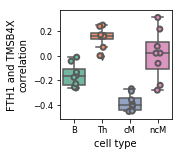

In [26]:
# EEF1A1	EEF1D

plt.figure(figsize=(2, 2))
gene_1, gene_2 = 'FTH1', 'TMSB4X'
plot_df = get_ct_ind_corr(adata_ct, gene_1, gene_2).query('ct in ["B","Th","cM","ncM"]')
sns.boxplot(x='ct', y='corr',
    data=plot_df, 
    palette='Set2')
sns.stripplot(x='ct', y='corr',
    data=plot_df, 
    palette='Set2', linewidth=2)
plt.ylabel('FTH1 and TMSB4X\ncorrelation')
plt.xlabel('cell type')
# plt.title('Correlation\nbetween\nFTH1 and TMSB4X')
plt.savefig(fig_path + 'fth1_tmsb4x.pdf', bbox_inches='tight')

In [27]:
norm_adata = adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
# sc.pp.log1p(norm_adata)

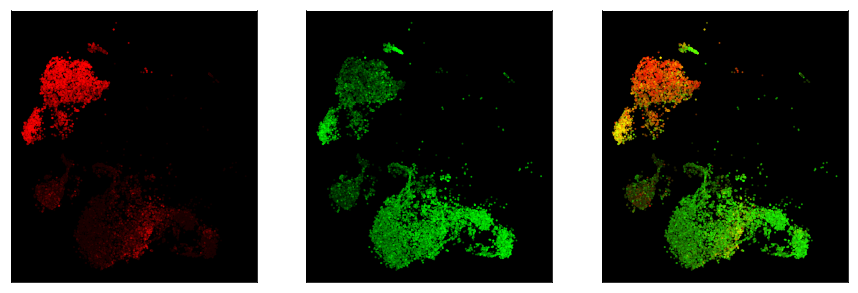

In [656]:
plt.figure(figsize=(15, 5))
plot_ct = 'CD14+ Monocytes'
dat = norm_adata[(norm_adata.obs.stim == 'ctrl')]
plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    s=1,
    q_down=0.0,
    q_up=0.9, 
    alpha=0.5,
    remove_axis=True)

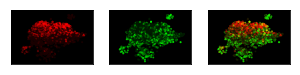

In [650]:
plt.figure(figsize=(5, 1))
plot_ct = 'CD14+ Monocytes'
dat = norm_adata[(norm_adata.obs.stim == 'ctrl') & (norm_adata.obs.cell == plot_ct)]
plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    s=1,
    q_down=0.5,
    q_up=0.9, 
    alpha=0.5,
    remove_axis=True,
    xlim=(-40, -5),ylim=(2, 37))
plt.savefig(fig_path + 'fth1_tmsb4x_cd14.pdf', bbox_inches='tight')

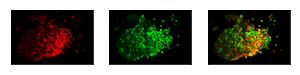

In [651]:
plt.figure(figsize=(5, 1))
plot_ct = 'CD4 T cells'
dat = norm_adata[(norm_adata.obs.stim == 'ctrl') & (norm_adata.obs.cell == plot_ct)]
plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    s=1,
    q_down=0.5,
    q_up=0.9, 
    alpha=0.5,
    remove_axis=True,
    xlim=(-25, 25),ylim=(-40, 0))
plt.savefig(fig_path + 'fth1_tmsb4x_cd4.pdf', bbox_inches='tight')

### Scratch

In [34]:
norm_adata = adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
sc.pp.log1p(norm_adata)

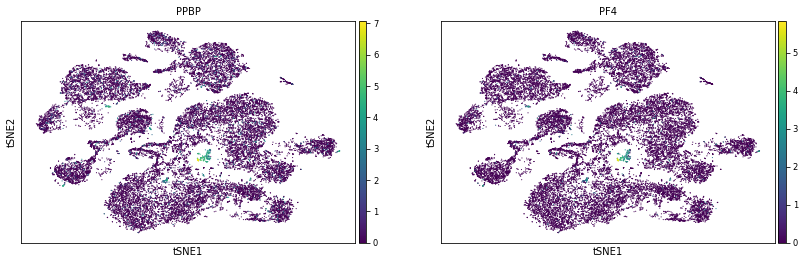

In [35]:
sc.pl.tsne(norm_adata, color=['PPBP', 'PF4'])

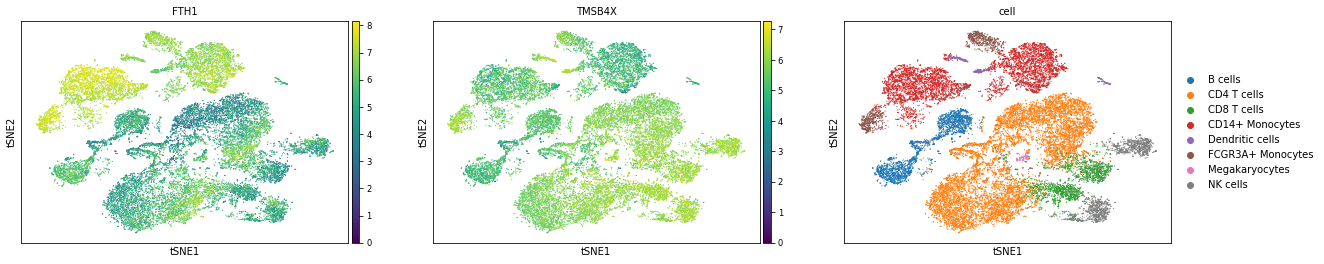

In [36]:
sc.pl.tsne(norm_adata, color=['FTH1', 'TMSB4X', 'cell'])